In [1]:
import sys
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.distributed as dist
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torch.multiprocessing as mp
import time
from requests import get
import os
import random
import math
import pickle
import argparse
import wandb
import gc

from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel

In [2]:
def GenerateDataset_p(ndig, nextra):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'+': 10,'=': 11}

    data = []
    target = []
    data_f = []
    target_f = []

    k = 0
    while k < 200000:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i+j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < ndig+nextra:
            lij = ['0'] * (ndig+nextra - len(lij)) + lij

        lsum = li + ['+'] + lj + lij
        lt = lsum[1:] + ['=']
        data.append([stoi[lsum[i]] for i in range(len(lsum))])
        target.append([stoi[lt[i]] for i in range(len(lt))])

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i + j < 10**(ndig+nextra))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i+j}')
        if len(li) < ndig+nextra:
            li = ['0'] * (ndig+nextra - len(li)) + li
        if len(lj) < ndig+nextra:
            lj = ['0'] * (ndig+nextra - len(lj)) + lj
        if len(lij) < ndig+nextra:
            lij = ['0'] * (ndig+nextra - len(lij)) + lij

        lsum = li + ['+'] + lj + lij
        lt = lsum[1:] + ['=']
        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        k += 1

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, data_f, target_f

class Dataset(torch.utils.data.Dataset):

    def __init__(self, inputs, target):
        self.inputs = inputs
        self.target = target

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        src = self.inputs[index]
        tgt = self.target[index]

        return src, tgt
    
def prepare(rank, world_size, data, target, batch_size, pin_memory=True, num_workers=0):

    dataset = Dataset(data, target)
    # sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False, drop_last=False)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False)
    
    return dataloader

def cleanup():
    dist.destroy_process_group()

def run_epoch(data, loader, model, optimizer, device, status='train'):

    for i, batch in enumerate(loader):

        src, tgt = batch[0].to(device), batch[1].to(device)

        seq_len = src.shape[-1]
        num_digits = (seq_len - 1) // 3

        logits = model.forward(src, num_last_tokens=num_digits+1).logits
        
        logits = F.log_softmax(logits, dim=-1)

        tgt = tgt[:, -(num_digits + 1):]

        kl_loss = nn.CrossEntropyLoss()

        loss = kl_loss(logits.transpose(-1, -2), tgt) # We want inputs to be (bs, vocab_size, seq len), so needed a transpose. Targets are (bs, seq len) with values in [0, vocab_size]

        a = (torch.argmax(logits.detach(), dim=-1) == tgt).float()

        acc_p = sum((torch.argmax(logits.detach(), dim=-1)[i] == tgt[i]).float().min() for i in range(len(tgt))) / len(tgt)

        a = a.mean(dim=0).tolist()
        a.append(acc_p)
        a.append(loss.detach().item())

        if status == 'train':
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        if status == 'eval':
            w2 = sum((p.data**2).sum() for p in model.parameters()).clone().detach().to('cpu')
            a.append(w2.item())
        
        pre_data = torch.tensor(a) # accuracy per token, correctness, loss
        data = torch.cat((data, pre_data.unsqueeze(0)), 0)
        
        if i % 100 == 0:
            print(f'---{status} loss ---')
            print(loss.detach().item())
            print(acc_p.detach().item())

        del loss, tgt, src, logits
        gc.collect

    return data

def train(args):

    ### Dataset

    print('--- Generating data ---')
    vocab, data, target, data_f, target_f = GenerateDataset_p(ndig=args.ndigits, nextra = args.nextra)
    print('--- Finished generating data ---')
    # Three way split (training, test)
    random.seed()
    z = list(zip(data.tolist(), target.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_array_sh, tgt_array_sh = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    rank = torch.device('cuda:0')
    world_size = 0

    # Dataset parameters

    batch_size = args.batch_size
    batch_size_eval = args.batch_size_eval

    split = args.split

    n1 = int(split*len(src_array_sh))
    n2 = 2*n1
    # n1 = 0
    # n0 = 100
    priming_examples = 0

    src_train, src_test = src_array_sh[:n1], src_array_sh[n1:n2]
    tgt_train, tgt_test = tgt_array_sh[:n1], tgt_array_sh[n1:n2]
    src_long, tgt_long = data_f[:priming_examples], target_f[:priming_examples]
    src_test_long, tgt_test_long = data_f[priming_examples:], target_f[priming_examples:]

    # src_train = torch.cat((src_train, src_long), 0)
    # tgt_train = torch.cat((tgt_train, tgt_long), 0)
    # src_train = src_long
    # tgt_train = tgt_long

    random.seed()
    z = list(zip(src_train.tolist(), tgt_train.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_train, tgt_train = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    dataloader_train = prepare(rank, world_size, src_train, tgt_train, batch_size)

    dataloader_test = prepare(rank, world_size, src_test, tgt_test, batch_size_eval)

    dataloader_test_long = prepare(rank, world_size, src_test_long, tgt_test_long, batch_size_eval)

    ### Model

    d_model = args.d_model
    n_layer = args.num_layers

    model = MambaLMHeadModel(d_model=d_model, n_layer=n_layer, vocab_size=vocab, device='cuda:0')  

    model = model.to(rank)

    ### Training parameters and optimizer

    lr = args.learning_rate
    weight_decay = args.weight_decay    
    num_epochs = args.epochs

    # warmup = 100
    # lr_max = 1e-3
    # lr_min = 3e-4
    # lr_decay_steps = 10000

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr = lr,
                                  betas = (0.9, 0.95),
                                  eps=1e-8,
                                  weight_decay=weight_decay)
    
    # lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda = lambda step: 1+0*(1/lr_max)*rate_cos(step, 
    #                                                                            warmup=warmup, 
    #                                                                            lr_max=lr_max, 
    #                                                                            lr_min=lr_min, 
    #                                                                            lr_decay_steps=lr_decay_steps) )

    ### Tracking

    wandb.init(project="Mamba arithmetic generative", 
                     config={"lr": lr, 
                             "split":split, 
                             "layers": n_layer, 
                             "weight decay": weight_decay, 
                             "d_model": d_model,
                             "Priming examples": priming_examples, 
                             "Batch size train": batch_size, 
                             "Batch size eval": batch_size_eval, 
                             'Task': f'{args.ndigits + args.nextra} digit addition sums', 
                             'ID': args.ID, 
                             "num digits train": args.ndigits})


    ### Training    

    for epoch in range(num_epochs):
        print(f' --- {epoch} ---')
        data = torch.tensor([])
        data_t = torch.tensor([])
        data_tl = torch.tensor([])

        model.train()
        data = run_epoch(data, loader=dataloader_train, model=model, optimizer=optimizer, device=rank, status='train')
        
        data = data.mean(dim=0)
        s = {}
        s['training loss'] = data[-1]
        z = [f'training acc. pos {i}' for i in range(args.ndigits + args.nextra + 1)]
        for i in range(len(z)):
            s[z[i]] = data[i]
        s['training acc.'] = data[-2].mean()
        wandb.log(s,
            step=epoch
            )

        model.eval()
        with torch.no_grad():
            data_t = run_epoch(data_t, loader=dataloader_test, model=model, optimizer=optimizer, device=rank, status='eval')

            data_tl = run_epoch(data_tl, loader=dataloader_test_long, model=model, optimizer=optimizer, device=rank, status='eval')

        data = data_t.mean(dim=0)
        data_long = data_tl.mean(dim=0)

        s = {}
        s['test loss'] = data[-2]
        z = [f'test acc. pos {i}' for i in range(args.ndigits + args.nextra + 1)]
        for i in range(len(z)):
            s[z[i]] = data[i]
        s['test acc.'] = data[-3]
        s['norm weights squared'] = data[-1]

        s['test loss long'] = data_long[-2]
        z = [f'test acc. pos {i} long' for i in range(args.ndigits + args.nextra + 1)]
        for i in range(len(z)):
            s[z[i]] = data_long[i]
        s['test acc. long'] = data_long[-3]
        wandb.log(s,
            step=epoch
            )

        if epoch % 50 == 0:
            outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_epoch{!s}'.format(n_layer, split, weight_decay, epoch)

            torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, outputFile)

    # cleanup()
    wandb.finish()

    outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_{!s}_final'.format(n_layer, split, weight_decay, args.ID)

    torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
            }, outputFile)
    return model

In [6]:
parser = argparse.ArgumentParser()

parser.add_argument("--split", default=0.5, type=float)
parser.add_argument("--weight_decay", default=0.01, type=float)
parser.add_argument("--num_layers", default=6, type=int)
parser.add_argument("--d_model", default=64, type=int)
parser.add_argument("--epochs",default=100, type=int)
parser.add_argument("--batch_size",default=32, type=int)
parser.add_argument("--batch_size_eval",default=1024, type=int)
parser.add_argument("--learning_rate",default=3e-3, type=float)
parser.add_argument("--ID", default=3, type=int)
parser.add_argument("--ndigits", default=5, type=int)
parser.add_argument("--nextra", default=5, type=int)
parser.add_argument("--output_dir", default="mamba_models_generative/", type=str)

args = parser.parse_args(args=[])

model = train(args)

--- Generating data ---
--- Finished generating data ---


norm weights squared,█▃▂▂▁▁▁▁▁▁▁▁▁▁
test acc.,▁▄▄▇▇▇▇▇▇██▇█▇
test acc. long,▁▁▃█▃▃▄▂▂▄▂▁▅▂
test acc. pos 0,▁██▃▃██▃▃█████
test acc. pos 0 long,██▇▇▄▃▅▁▁▂▃▅▅▁
test acc. pos 1,████████▁█████
test acc. pos 1 long,▇▇▇█▂▃▅▂▃▂▂▆▇▁
test acc. pos 10,█▇█▂▇███▁█████
test acc. pos 10 long,▁▃▂▁▄▃▂▄▆▅▇▆▇█
test acc. pos 2,▇████▇▁███████
test acc. pos 2 long,█▅▆▇▅▅▆▄▃▃▄▄▄▁


 --- 0 ---
---train loss ---
2.1354007720947266
0.0
---train loss ---
0.8087169528007507
0.0
---train loss ---
0.8992887735366821
0.03125
---train loss ---
0.7350298166275024
0.0
---train loss ---
0.7109223008155823
0.0
---train loss ---
0.6374480128288269
0.03125
---train loss ---
0.6963624358177185
0.0
---train loss ---
0.5609874725341797
0.125
---train loss ---
0.5515245199203491
0.03125
---train loss ---
0.5722057223320007
0.03125
---train loss ---
0.48006173968315125
0.15625
---train loss ---
0.47704583406448364
0.125
---train loss ---
0.5175455212593079
0.03125
---train loss ---
0.47143813967704773
0.21875
---train loss ---
0.3276655972003937
0.3125
---train loss ---
0.23708638548851013
0.4375
---train loss ---
0.2848615050315857
0.1875
---train loss ---
0.33853113651275635
0.125
---train loss ---
0.21970447897911072
0.40625
---train loss ---
0.18248699605464935
0.5625
---train loss ---
0.2661783993244171
0.34375
---train loss ---
0.217071995139122
0.46875
---train loss ---
0.172

KeyboardInterrupt: 

In [7]:
vocab, data, target, data_f, target_f = GenerateDataset(3, 3)

In [8]:
model = MambaLMHeadModel(128, 2, 12, device='cuda:1')

In [9]:
out = model.forward(data[:10].to('cuda:1'))

In [12]:
out.logits[:, -6:]

torch.Size([10, 6, 12])

In [18]:
output_file = 'mamba_models/model_n2_s0.3_w0.2_0'
n_layer = 2 # number of layers
d_model = 128 # model dimension, residual stream
vocab = 12

model = MambaLMHeadModel(d_model = d_model, n_layer=n_layer, vocab_size=vocab, device='cuda:1')

model.load_state_dict(torch.load(output_file)['model'])

model = model.to('cuda:1')

In [14]:
Embed = model.backbone.embedding.weight.detach().to('cpu')

In [15]:
import matplotlib.pyplot as plt

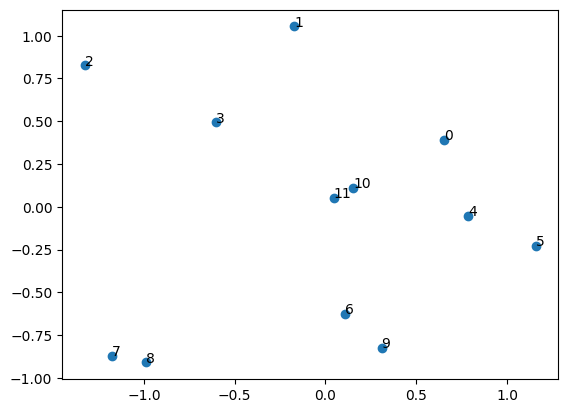

In [16]:
svdEMB = torch.svd(Embed)

a, b = 1, 2

x = svdEMB[0][:, a] * svdEMB[1][a]
y = svdEMB[0][:, b] * svdEMB[1][b]

plt.scatter(x, y)

i = 0
for x, y in zip(x, y):
    plt.annotate(f'{i}', (x, y))
    i += 1

In [39]:
model

MambaLMHeadModel(
  (backbone): MixerModel(
    (embedding): Embedding(12, 128)
    (layers): ModuleList(
      (0-1): 2 x Block(
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=12, bias=False)
)

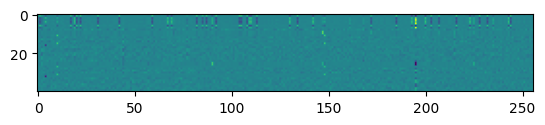

In [11]:
z = model.backbone.layers[0].mixer.x_proj.weight.detach().to('cpu')
plt.imshow(z)